**Rozdział 7. Uczenie zespołowe i losowe lasy**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 7._

# Konfiguracja

Upewnijmy się najpierw, że notatnik ten będzie działał w środowiskach Python 2 i 3, importujmy kilka powszechnie stosowanych modułów, upewnijmy się, że moduł MatplotLib będzie prawidłowo tworzył wykresy, a także przygotujmy funkcję zapisującą rysunki:

In [1]:
# Obsługa środowisk Python 2 i Python 3
from __future__ import division, print_function, unicode_literals

# Importowanie popularnych modułów
import numpy as np
import os

# W celu zachowania powtarzalności wyników w kolejnych przebiegach
np.random.seed(42)

# Generowanie ładnych wykresów
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Lokacja, w której będą zapisywane rysunki
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "zespoly"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

# Klasyfikatory głosujące

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Zapisywanie rysunku wykres_prawa_wielkich_liczb


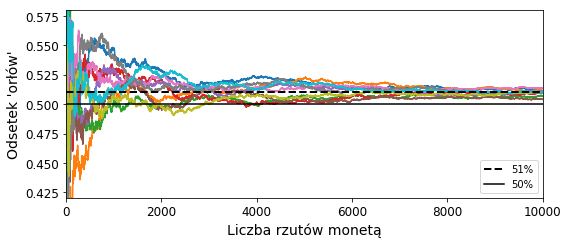

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Liczba rzutów monetą")
plt.ylabel("Odsetek 'orłów'")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("wykres_prawa_wielkich_liczb")
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[(u'lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), (u'rf', RandomF...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting=u'hard', weights=None)

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [7]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[(u'lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), (u'rf', RandomF...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting=u'soft', weights=None)

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


# Zespoły agregujące

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [11]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [12]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Zapisywanie rysunku wykres_drzewa_decyzyjnego_bez_agregacji_i_z_agregacją


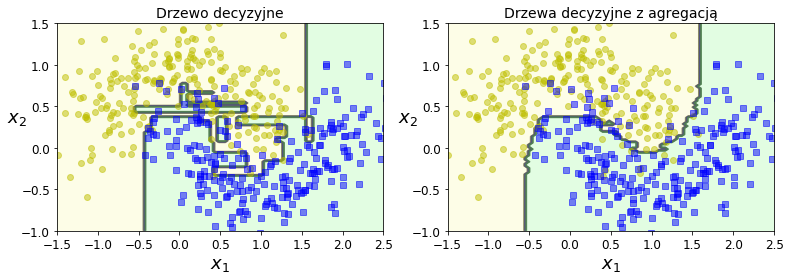

In [13]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Drzewo decyzyjne", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Drzewa decyzyjne z agregacją", fontsize=14)
save_fig("wykres_drzewa_decyzyjnego_bez_agregacji_i_z_agregacją")
plt.show()

# Losowe lasy

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [15]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [17]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # niemal identyczne prognozy

0.97599999999999998

In [18]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.112492250999
sepal width (cm) 0.0231192882825
petal length (cm) 0.441030464364
petal width (cm) 0.423357996355


In [19]:
rnd_clf.feature_importances_

array([ 0.11249225,  0.02311929,  0.44103046,  0.423358  ])

Zapisywanie rysunku wykres_drzewa_decyzyjnego_permutacje_przykladow


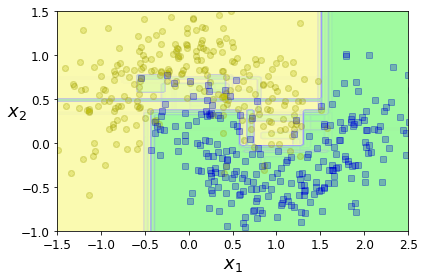

In [26]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

save_fig("wykres_drzewa_decyzyjnego_permutacje_przykladow")
plt.show()

## Ocena OOB

In [23]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.90133333333333332

In [24]:
bag_clf.oob_decision_function_

array([[ 0.31746032,  0.68253968],
       [ 0.34117647,  0.65882353],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.08379888,  0.91620112],
       [ 0.31693989,  0.68306011],
       [ 0.02923977,  0.97076023],
       [ 0.97687861,  0.02312139],
       [ 0.97765363,  0.02234637],
       [ 0.74404762,  0.25595238],
       [ 0.        ,  1.        ],
       [ 0.71195652,  0.28804348],
       [ 0.83957219,  0.16042781],
       [ 0.97777778,  0.02222222],
       [ 0.0625    ,  0.9375    ],
       [ 0.        ,  1.        ],
       [ 0.97297297,  0.02702703],
       [ 0.95238095,  0.04761905],
       [ 1.        ,  0.        ],
       [ 0.01704545,  0.98295455],
       [ 0.38947368,  0.61052632],
       [ 0.88700565,  0.11299435],
       [ 1.        ,  0.        ],
       [ 0.96685083,  0.03314917],
       [ 0.        ,  1.        ],
       [ 0.99428571,  0.00571429],
       [ 1.        ,  0.        ],
       [ 0.        ,

In [25]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.91200000000000003

## Istotność cech

In [52]:
from six.moves import urllib
from scipy.io import loadmat

mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}

In [28]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [29]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Zapisywanie rysunku wykres_istotności_cech_w_zestawie_mnist


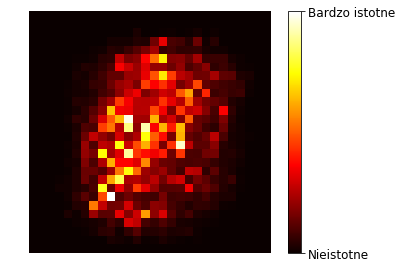

In [30]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Nieistotne', 'Bardzo istotne'])

save_fig("wykres_istotności_cech_w_zestawie_mnist")
plt.show()

# AdaBoost

In [31]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm=u'SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

Zapisywanie rysunku wykres_AdaBoostClassifier


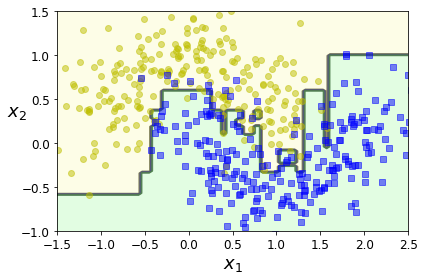

In [32]:
plot_decision_boundary(ada_clf, X, y)
save_fig("wykres_AdaBoostClassifier")

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Zapisywanie rysunku wykres_wzmacniania


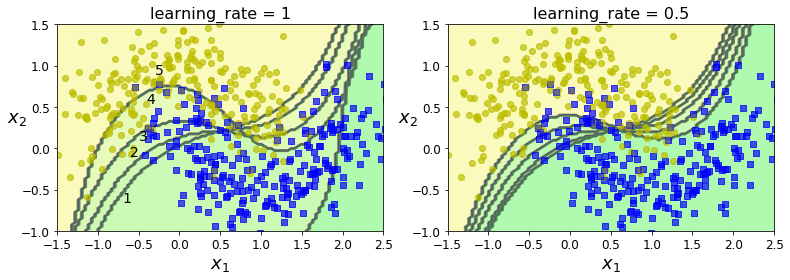

In [33]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)
save_fig("wykres_wzmacniania")
plt.show()

In [31]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

# Wzmacnianie gradientowe

In [34]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [36]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [37]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [38]:
X_new = np.array([[0.8]])

In [39]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [40]:
y_pred

array([ 0.75026781])

Zapisywanie rysunku wykres_wzmacniania_gradientowego


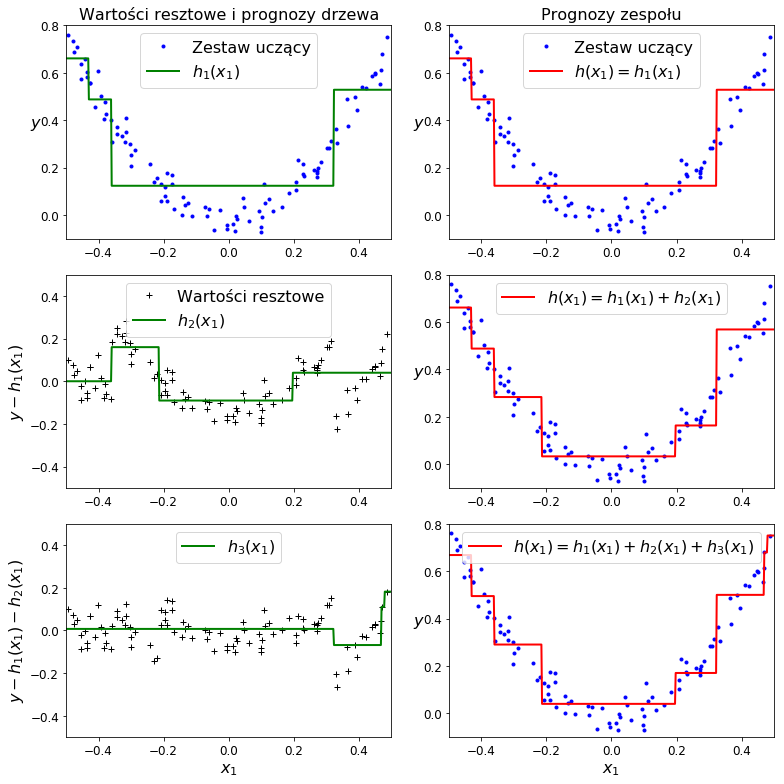

In [41]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Zestaw uczący")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Wartości resztowe i prognozy drzewa", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Zestaw uczący")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Prognozy zespołu", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Wartości resztowe")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("wykres_wzmacniania_gradientowego")
plt.show()

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [43]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

Zapisywanie rysunku wykres_współczynnika_uczenia_drzewa_gbrt


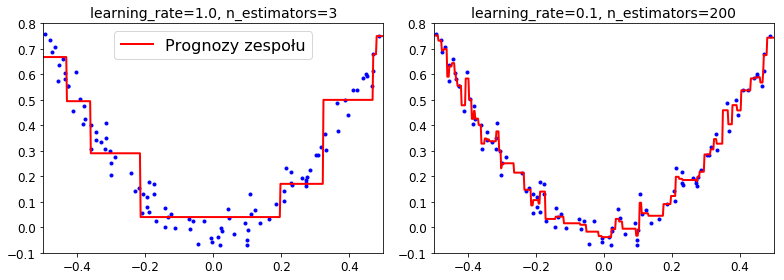

In [44]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Prognozy zespołu")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("wykres_współczynnika_uczenia_drzewa_gbrt")
plt.show()

## Wzmacnianie gradientowe ze wczesnym zatrzymywaniem

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [46]:
min_error = np.min(errors)

Zapisywanie rysunku wykres_drzewa_gbrt_ze_wczesnym_zatrzymywaniem


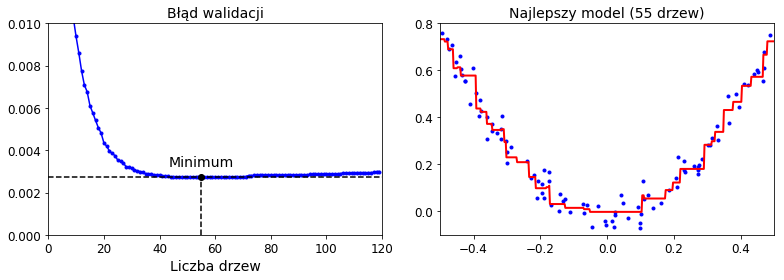

In [47]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Liczba drzew")
plt.title("Błąd walidacji", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Najlepszy model (%d drzew)" % bst_n_estimators, fontsize=14)

save_fig("wykres_drzewa_gbrt_ze_wczesnym_zatrzymywaniem")
plt.show()

In [48]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # wczesne zatrzymywanie

In [49]:
print(gbrt.n_estimators)

61


# Rozwiązania ćwiczeń

## 1. do 7.

Patrz dodatek A.

## 8. Klasyfikator głosujący

Ćwiczenie: _Wczytaj zbiór danych MNIST i podziel go na podzbiory uczący, walidacyjny i testowy (np. używając 40,000 próbek do trenowania, 10,000 do walidacji i 10,000 do testowania)._

Zbiór danych MNIST został wczytany wcześniej.

In [50]:
from sklearn.model_selection import train_test_split

In [57]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist["data"], mnist["target"], test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Ćwiczenie: _Następnie wytrenuj różne klasyfikatory, np. losowego lasu, Extra-Trees czy SVM._

In [58]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [60]:
random_forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=10, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [61]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
Training the LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr',

In [62]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.94669999999999999, 0.95120000000000005, 0.8327, 0.95820000000000005]

Liniowy klasyfikator SVM jest daleko z tyle za innymi klasyfikatorami. Pozostawmy go jednak, ponieważ może poprawić działanie klasyfikatora głosującego.

Ćwiczenie: _Teraz spróbuj połączyć je w jeden zespół (korzystając z klasyfikatora głosowania większościowego lub miękkiego), który będzie osiągał lepsze wyniki wobec zestawu walidacyjnego w stosunku do elementów składowych._

In [63]:
from sklearn.ensemble import VotingClassifier

In [64]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [65]:
voting_clf = VotingClassifier(named_estimators)

In [66]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[(u'random_forest_clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
  ...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [67]:
voting_clf.score(X_val, y_val)

0.96509999999999996

In [68]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.94669999999999999, 0.95120000000000005, 0.8327, 0.95820000000000005]

Usuńmy teraz klasyfikator SVM aby zobaczyć, czy spowoduje to poprawę działania. Możliwe jest usunięcie estymatora poprzez ustawienie jego wartości równej `None`, używając metody `set_params()` w następujący sposób:

In [69]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[(u'random_forest_clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
  ...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

Zaktualizowana lista estymatorów:

In [70]:
voting_clf.estimators

[(u'random_forest_clf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 (u'extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('svm_clf', None),
 (u'mlp_clf',
  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
    

Jednakże, nie spowodowało to aktualizacji listy _wyuczonych_ estymatorów zawartych w klasyfikatorze głosującym:

In [69]:
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', r

Możemy więc wyuczyć klasyfikator `VotingClassifier` ponownie, albo po prostu ręcznie usunąć SVM z listy wyuczonych przez klasyfikator głosujący estymatorów:

In [71]:
del voting_clf.estimators_[2]

Obliczmy ponownie wynik działania `VotingClassifier`:

In [72]:
voting_clf.score(X_val, y_val)

0.96719999999999995

Trochę lepiej! Klasyfikator SVM zaniżał dokładność działania. Spróbujmy teraz użyć klasyfikatora korzystającego z głosowania miękkiego. Nie potrzebujemy ponownie trenować klasyfikatora, wystarczy że ustawimy parametr `voting` jako `"soft"`:

In [73]:
voting_clf.voting = "soft"

In [74]:
voting_clf.score(X_val, y_val)

0.97060000000000002

Jest to znacząca poprawa, w dodatku zespół działa dużo lepiej od każdego z poszczególnych klasyfikatorów!

_Po uzyskaniu takiego modelu wypróbuj go na zbiorze testowym. O ile lepiej sprawuje się ten zespół w porównaniu do poszczególnych klasyfikatorów?_

In [75]:
voting_clf.score(X_test, y_test)

0.96599999999999997

In [76]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.94340000000000002, 0.94440000000000002, 0.95409999999999995]

Klasyfikator głosujący zredukował błąd z ok. 4.0% dla naszego najlepszego modelu (`MLPClassifier`) do jedynie 3.1%. To o około 22.5% mniej błędów, zatem nie jest źle!

## 9. Zespół kontaminacji

Ćwiczenie: _Uruchom poszczególne klasyfikatory utworzone w poprzednim ćwiczeniu w celu wyliczenia prognoz dla zbioru walidacyjnego, a następnie utwórz nowy zbiór danych zawierający te predykcje: każdy przykład uczący ma stanowić wektor przechowujący zbiór prognoz pochodzących z pojedynczych klasyfikatorów dla obrazu, natomiast wartością docelową niech będzie klasa obrazu. Wytrenuj klasyfikator na tym nowym zbiorze uczącym._

In [77]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [78]:
X_val_predictions

array([[ 2.,  2.,  2.,  2.],
       [ 7.,  7.,  7.,  7.],
       [ 4.,  4.,  4.,  4.],
       ..., 
       [ 4.,  4.,  4.,  4.],
       [ 9.,  9.,  9.,  9.],
       [ 4.,  4.,  4.,  4.]], dtype=float32)

In [79]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [80]:
rnd_forest_blender.oob_score_

0.96460000000000001

Możesz wyregulować wyuczony mikser lub wypróbować inne rodzaje mikserów (np. `MLPClassifier`), a następnie wybrać najlepszy używając (jak zawsze) kroswalidacji.

Ćwiczenie: _Gratulacje! Właśnie udało Ci się wyuczyć mikser, który wraz z klasyfikatorami tworzy zespół kontaminacji. Sprawdźmy teraz wydajność tego zespołu wobec danych testowych. Dla każdego obrazu w zbiorze testowym oblicz prognozy za pomocą wszystkich klasyfikatorów, a następnie prześlij wynik do miksera, aby uzyskać przewidywania zespołu. Porównaj wyniki z utworzonym wcześniej klasyfikatorem głosującym._

In [81]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [82]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [83]:
from sklearn.metrics import accuracy_score

In [84]:
accuracy_score(y_test, y_pred)

0.95830000000000004